In [1]:
import requests
import pandas as pd
import numpy as np
import sys
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
link = 'https://api.covidactnow.org/v2/county/CA.timeseries.csv?apiKey=6b402fb107d14cac9ecf93a83992bc49'

cc_data = pd.read_csv(link)

cc_data = pd.DataFrame(cc_data)

cc_data.head()

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.contactTracers,actuals.hospitalBeds.capacity,actuals.hospitalBeds.currentUsageTotal,actuals.hospitalBeds.currentUsageCovid,unused1,actuals.icuBeds.capacity,actuals.icuBeds.currentUsageTotal,actuals.icuBeds.currentUsageCovid,unused2,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,metrics.testPositivityRatio,metrics.testPositivityRatioDetails,metrics.caseDensity,metrics.contactTracerCapacityRatio,metrics.infectionRate,metrics.infectionRateCI90,unused3,unused4,metrics.icuCapacityRatio,riskLevels.overall,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,riskLevels.caseDensity,cdcTransmissionLevel
0,2020-03-01,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,3
1,2020-03-02,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.118,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,0,3
2,2020-03-03,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.111,NaN,0.0,NaN,1.17,1.03,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,0,3
3,2020-03-04,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.065,NaN,0.0,NaN,1.18,0.85,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,0,1
4,2020-03-05,US,CA,Alameda County,6001,NaN,NaN,iso1:us#iso2:us-ca#fips:06001,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.065,NaN,0.0,NaN,1.20,0.80,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,0,1


In [3]:
county_df = cc_data
county_df.drop(columns = ['lat', 'long', 'locationId', 'actuals.negativeTests', 'actuals.contactTracers', 'actuals.hospitalBeds.capacity',
                          'actuals.hospitalBeds.currentUsageTotal', 'actuals.hospitalBeds.currentUsageCovid', 'unused1', 'actuals.icuBeds.capacity',
                          'actuals.icuBeds.currentUsageTotal', 'actuals.icuBeds.currentUsageCovid', 'unused2', 'metrics.testPositivityRatio',
                          'metrics.testPositivityRatioDetails', 'metrics.caseDensity', 'metrics.contactTracerCapacityRatio', 'metrics.infectionRate',
                          'metrics.infectionRateCI90', 'unused3', 'unused4', 'metrics.icuCapacityRatio', 'riskLevels.overall', 
                          'metrics.vaccinationsInitiatedRatio', 'metrics.vaccinationsCompletedRatio', 'riskLevels.caseDensity', 'cdcTransmissionLevel'], inplace = True)

county_df.rename(columns = {'actuals.cases':'cases', 'actuals.deaths':'deaths', 'actuals.vaccinationsCompleted':'vaccinations'}, inplace=True)

county_df

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered
0,2020-03-01,US,CA,Alameda County,6001,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,US,CA,Alameda County,6001,1.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
2,2020-03-03,US,CA,Alameda County,6001,2.0,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN
3,2020-03-04,US,CA,Alameda County,6001,2.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
4,2020-03-05,US,CA,Alameda County,6001,2.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37460,2021-12-09,US,CA,Yuba County,6115,11348.0,92.0,NaN,0.0,NaN,38729.0,34836.0,1.0,76782.0
37461,2021-12-10,US,CA,Yuba County,6115,11376.0,92.0,NaN,28.0,NaN,38763.0,34904.0,0.0,77080.0
37462,2021-12-11,US,CA,Yuba County,6115,11376.0,92.0,NaN,0.0,NaN,38788.0,34941.0,0.0,77203.0
37463,2021-12-12,US,CA,Yuba County,6115,11376.0,92.0,NaN,0.0,NaN,38799.0,34971.0,0.0,77282.0


In [4]:
county_df

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered
0,2020-03-01,US,CA,Alameda County,6001,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,US,CA,Alameda County,6001,1.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
2,2020-03-03,US,CA,Alameda County,6001,2.0,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN
3,2020-03-04,US,CA,Alameda County,6001,2.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
4,2020-03-05,US,CA,Alameda County,6001,2.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37460,2021-12-09,US,CA,Yuba County,6115,11348.0,92.0,NaN,0.0,NaN,38729.0,34836.0,1.0,76782.0
37461,2021-12-10,US,CA,Yuba County,6115,11376.0,92.0,NaN,28.0,NaN,38763.0,34904.0,0.0,77080.0
37462,2021-12-11,US,CA,Yuba County,6115,11376.0,92.0,NaN,0.0,NaN,38788.0,34941.0,0.0,77203.0
37463,2021-12-12,US,CA,Yuba County,6115,11376.0,92.0,NaN,0.0,NaN,38799.0,34971.0,0.0,77282.0


In [5]:
county_df = county_df[county_df['date'] >= '2020-04-01']

In [6]:
county_df['cases'] = county_df['cases'].interpolate(limit_area = 'inside')
county_df['deaths'] = county_df['deaths'].interpolate(limit_area = 'inside')
county_df['vaccinations'] = county_df['vaccinations'].interpolate(imit_area = 'inside')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [7]:
dailycases = county_df.copy()
dailycases['Daily_Cases'] = (
    dailycases.groupby(['county'])['cases']
    .transform(lambda s: s.sub(s.shift().fillna(0)).abs())
)

In [8]:
movingavg = dailycases.Daily_Cases.rolling(window=7).mean().round().fillna(0)
dailycases['Moving_7_Day_Avg'] = movingavg

In [9]:
groupdf = dailycases.groupby('county')

gbdf = [groupdf.get_group(x) for x in groupdf.groups]

gbdf[1]

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered,Daily_Cases,Moving_7_Day_Avg
655,2020-04-01,US,CA,Alpine County,6003,1.0,0.0,NaN,0.0,NaN,NaN,1.261577e+06,0.0,NaN,1.0,128.0
656,2020-04-02,US,CA,Alpine County,6003,1.0,0.0,NaN,0.0,NaN,NaN,1.256668e+06,0.0,NaN,0.0,114.0
657,2020-04-03,US,CA,Alpine County,6003,1.0,0.0,NaN,0.0,NaN,NaN,1.251759e+06,0.0,NaN,0.0,91.0
658,2020-04-04,US,CA,Alpine County,6003,1.0,0.0,NaN,0.0,NaN,NaN,1.246851e+06,0.0,NaN,0.0,72.0
659,2020-04-05,US,CA,Alpine County,6003,1.0,0.0,NaN,0.0,NaN,NaN,1.241942e+06,0.0,NaN,0.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,2021-12-09,US,CA,Alpine County,6003,108.0,0.0,NaN,0.0,NaN,827.0,7.120000e+02,0.0,1758.0,0.0,0.0
1273,2021-12-10,US,CA,Alpine County,6003,109.0,0.0,NaN,1.0,NaN,827.0,7.120000e+02,0.0,1759.0,1.0,0.0
1274,2021-12-11,US,CA,Alpine County,6003,109.0,0.0,NaN,0.0,NaN,827.0,7.120000e+02,0.0,1759.0,0.0,0.0
1275,2021-12-12,US,CA,Alpine County,6003,109.0,0.0,NaN,0.0,NaN,827.0,7.120000e+02,0.0,1759.0,0.0,0.0


In [10]:
clist = list(set(list(county_df['county'])))

clist = sorted(clist)
print(clist)

d = {}
i = 0

for x in clist:
  d[x] = gbdf[i]
  i += 1

d['San Diego County']

['Alameda County', 'Alpine County', 'Amador County', 'Butte County', 'Calaveras County', 'Colusa County', 'Contra Costa County', 'Del Norte County', 'El Dorado County', 'Fresno County', 'Glenn County', 'Humboldt County', 'Imperial County', 'Inyo County', 'Kern County', 'Kings County', 'Lake County', 'Lassen County', 'Los Angeles County', 'Madera County', 'Marin County', 'Mariposa County', 'Mendocino County', 'Merced County', 'Modoc County', 'Mono County', 'Monterey County', 'Napa County', 'Nevada County', 'Orange County', 'Placer County', 'Plumas County', 'Riverside County', 'Sacramento County', 'San Benito County', 'San Bernardino County', 'San Diego County', 'San Francisco County', 'San Joaquin County', 'San Luis Obispo County', 'San Mateo County', 'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County', 'Shasta County', 'Sierra County', 'Siskiyou County', 'Solano County', 'Sonoma County', 'Stanislaus County', 'Sutter County', 'Tehama County', 'Trinity County', 'Tulare Coun

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered,Daily_Cases,Moving_7_Day_Avg
23265,2020-04-01,US,CA,San Diego County,6073,849.0,15.0,NaN,115.0,NaN,NaN,1.132641e+06,6.0,NaN,849.0,619.0
23266,2020-04-02,US,CA,San Diego County,6073,966.0,16.0,NaN,117.0,NaN,NaN,1.128235e+06,1.0,NaN,117.0,582.0
23267,2020-04-03,US,CA,San Diego County,6073,1112.0,17.0,NaN,146.0,NaN,NaN,1.123830e+06,1.0,NaN,146.0,510.0
23268,2020-04-04,US,CA,San Diego County,6073,1209.0,18.0,NaN,97.0,NaN,NaN,1.119425e+06,1.0,NaN,97.0,434.0
23269,2020-04-05,US,CA,San Diego County,6073,1326.0,19.0,NaN,117.0,NaN,NaN,1.115020e+06,1.0,NaN,117.0,451.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23882,2021-12-09,US,CA,San Diego County,6073,414471.0,4369.0,NaN,826.0,NaN,2809352.0,2.442152e+06,12.0,5436751.0,826.0,840.0
23883,2021-12-10,US,CA,San Diego County,6073,415069.0,4374.0,NaN,598.0,NaN,2816257.0,2.448360e+06,5.0,5458326.0,598.0,832.0
23884,2021-12-11,US,CA,San Diego County,6073,415069.0,4374.0,NaN,0.0,NaN,2821155.0,2.452638e+06,0.0,5471430.0,0.0,832.0
23885,2021-12-12,US,CA,San Diego County,6073,415069.0,4374.0,NaN,0.0,NaN,2823566.0,2.454442e+06,0.0,5477102.0,0.0,832.0


In [11]:
listy = []
for x in d:
  listy.append(x)

In [12]:
popList = [1680480,
1209,
40446,
196880,
46319,
21805,
1159540,
27956,
197037,
1013400,
29245,
134186,
180599,
18225,
913090,
156056,
64524,
30483,
9969510,
158217,
257154,
16799,
85445,
284738,
8923,
14526,
434283,
135654,
100249,
3175130,
410327,
18939,
2520060,
1578680,
65490,
2206750,
3347270,
883255,
781462,
282625,
762357,
447937,
1918880,
271957,
180822,
3021,
43517,
451479,
485722,
555728,
98217,
67216,
11721,
469407,
54660,
841734,
221264,
80890]

In [13]:
 countydict = {listy[i]: popList[i] for i in range(0, len(listy), 1)}

In [14]:
countydict['Alpine County']

1209

In [15]:
for x in d:
  d[x]['population'] = countydict[x]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
d['San Diego County']

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered,Daily_Cases,Moving_7_Day_Avg,population
23265,2020-04-01,US,CA,San Diego County,6073,849.0,15.0,NaN,115.0,NaN,NaN,1.132641e+06,6.0,NaN,849.0,619.0,3347270
23266,2020-04-02,US,CA,San Diego County,6073,966.0,16.0,NaN,117.0,NaN,NaN,1.128235e+06,1.0,NaN,117.0,582.0,3347270
23267,2020-04-03,US,CA,San Diego County,6073,1112.0,17.0,NaN,146.0,NaN,NaN,1.123830e+06,1.0,NaN,146.0,510.0,3347270
23268,2020-04-04,US,CA,San Diego County,6073,1209.0,18.0,NaN,97.0,NaN,NaN,1.119425e+06,1.0,NaN,97.0,434.0,3347270
23269,2020-04-05,US,CA,San Diego County,6073,1326.0,19.0,NaN,117.0,NaN,NaN,1.115020e+06,1.0,NaN,117.0,451.0,3347270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23882,2021-12-09,US,CA,San Diego County,6073,414471.0,4369.0,NaN,826.0,NaN,2809352.0,2.442152e+06,12.0,5436751.0,826.0,840.0,3347270
23883,2021-12-10,US,CA,San Diego County,6073,415069.0,4374.0,NaN,598.0,NaN,2816257.0,2.448360e+06,5.0,5458326.0,598.0,832.0,3347270
23884,2021-12-11,US,CA,San Diego County,6073,415069.0,4374.0,NaN,0.0,NaN,2821155.0,2.452638e+06,0.0,5471430.0,0.0,832.0,3347270
23885,2021-12-12,US,CA,San Diego County,6073,415069.0,4374.0,NaN,0.0,NaN,2823566.0,2.454442e+06,0.0,5477102.0,0.0,832.0,3347270


In [17]:
for x in d:
  d[x]['Case_Rate'] = d[x]['Daily_Cases']/d[x]['population']
  d[x] = d[x][d[x]['Case_Rate'] <= 0.02]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [18]:
for x in d:
  d[x]['Avg_Rate'] = d[x]['Moving_7_Day_Avg']/d[x]['population']
  #d[x] = d[x][d[x]['Case_Rate'] <= 0.02]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
d['San Diego County'].head()

,date,country,state,county,fips,cases,deaths,actuals.positiveTests,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,vaccinations,actuals.newDeaths,actuals.vaccinesAdministered,Daily_Cases,Moving_7_Day_Avg,population,Case_Rate,Avg_Rate
23265,2020-04-01,US,CA,San Diego County,6073,849.0,15.0,NaN,115.0,NaN,NaN,1.132641e+06,6.0,NaN,849.0,619.0,3347270,0.000254,0.000185
23266,2020-04-02,US,CA,San Diego County,6073,966.0,16.0,NaN,117.0,NaN,NaN,1.128235e+06,1.0,NaN,117.0,582.0,3347270,0.000035,0.000174
23267,2020-04-03,US,CA,San Diego County,6073,1112.0,17.0,NaN,146.0,NaN,NaN,1.123830e+06,1.0,NaN,146.0,510.0,3347270,0.000044,0.000152
23268,2020-04-04,US,CA,San Diego County,6073,1209.0,18.0,NaN,97.0,NaN,NaN,1.119425e+06,1.0,NaN,97.0,434.0,3347270,0.000029,0.000130
23269,2020-04-05,US,CA,San Diego County,6073,1326.0,19.0,NaN,117.0,NaN,NaN,1.115020e+06,1.0,NaN,117.0,451.0,3347270,0.000035,0.000135


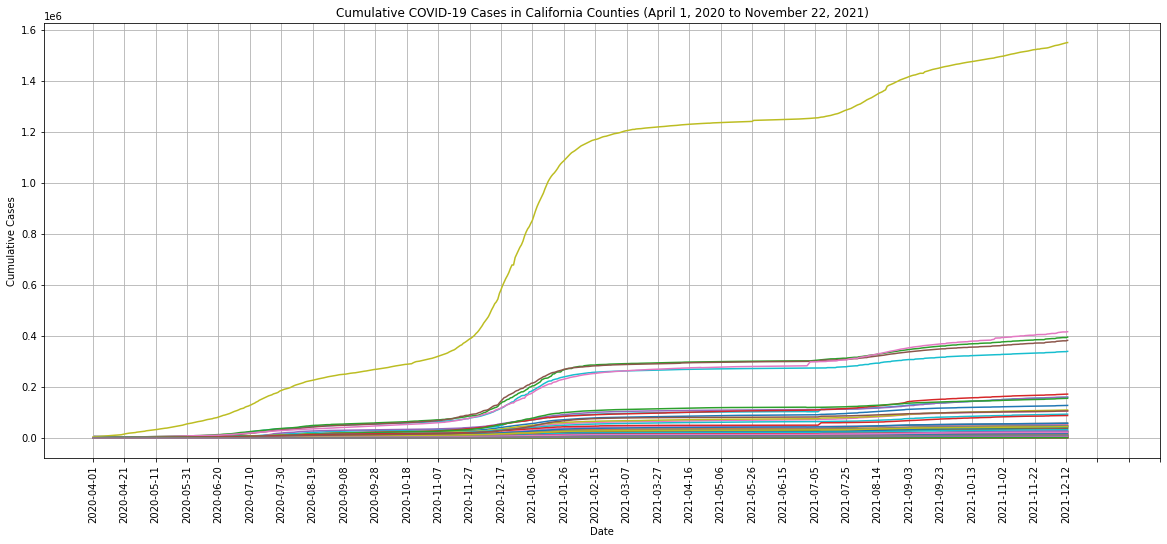

In [20]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases

for c in clist:
  plt.plot(d[c].date, d[c].cases, label = c)
  # Create a legend for the different lines that will be displayed
  #plt.legend(c)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Cumulative Cases")

ticks = range(0, 700, 20)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Cumulative COVID-19 Cases in California Counties (April 1, 2020 to November 22, 2021)")
plt.grid()

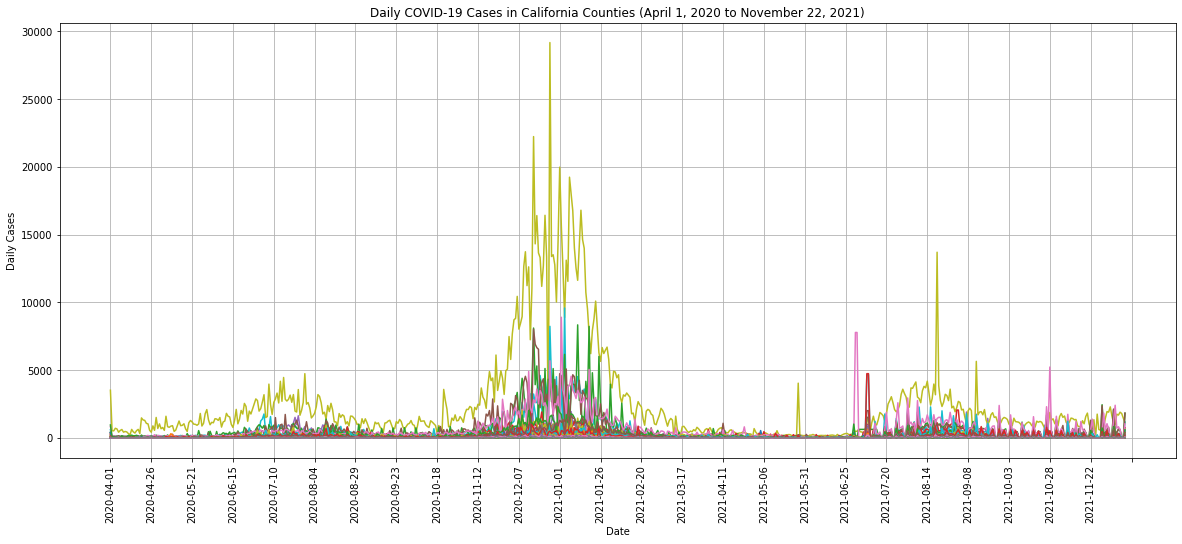

In [21]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
for c in clist:
  plt.plot(d[c].date, d[c].Daily_Cases, label = c)
  #Create a legend for the different lines that will be displayed
  #plt.legend(c)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Cases")

ticks = range(0, 650, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Cases in California Counties (April 1, 2020 to November 22, 2021)")
plt.grid()

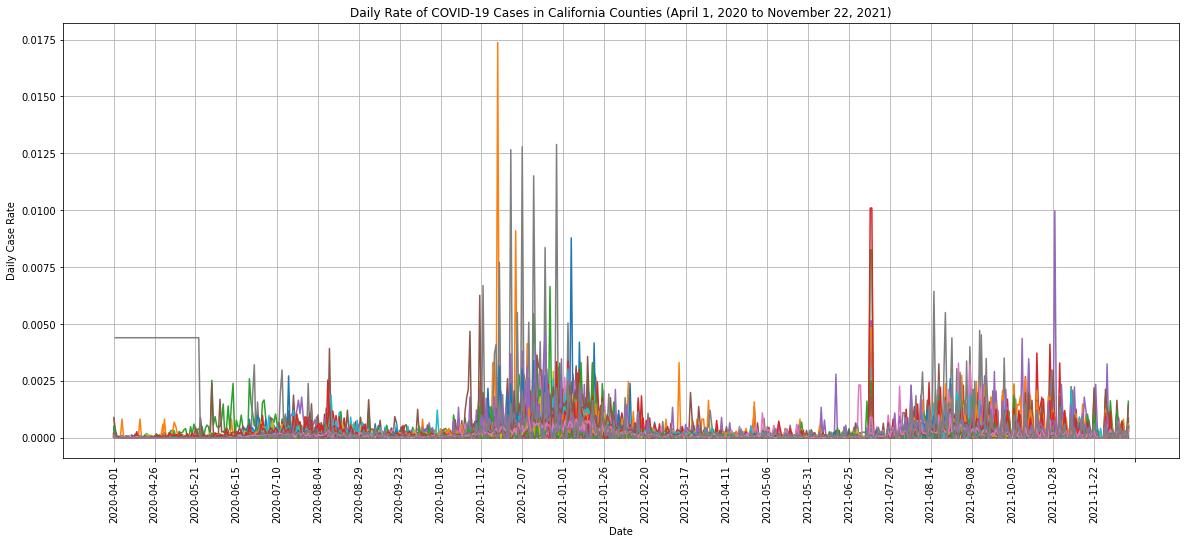

In [22]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
for c in clist:
  plt.plot(d[c].date, d[c].Case_Rate, label = c)
  #Create a legend for the different lines that will be displayed
  #plt.legend(c)



# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Case Rate")

ticks = range(0, 650, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily Rate of COVID-19 Cases in California Counties (April 1, 2020 to November 22, 2021)")
plt.grid()

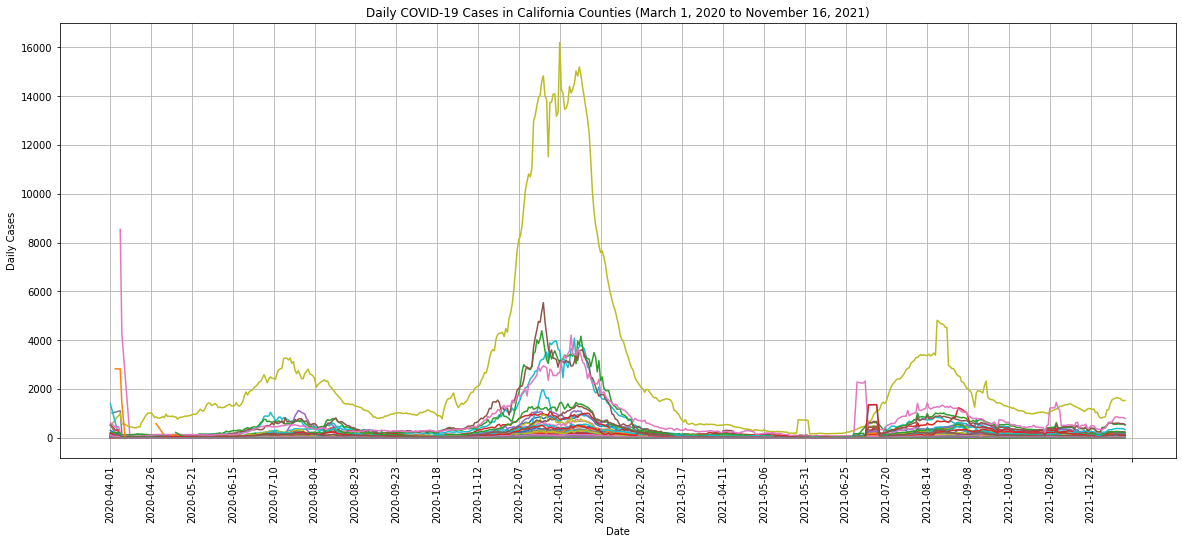

In [23]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
for c in clist:
  plt.plot(d[c].date, d[c].Moving_7_Day_Avg, label = c)
  # Create a legend for the different lines that will be displayed
  # plt.legend(c)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Cases")

ticks = range(0, 650, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Cases in California Counties (March 1, 2020 to November 16, 2021)")
plt.grid()

In [24]:
la = d['Los Angeles County']
la.reset_index(inplace = True)

sd = d['San Diego County']
sd.reset_index(inplace = True)

oc = d['Orange County']
oc.reset_index(inplace = True)

rs = d['Riverside County']
rs.reset_index(inplace = True)

sb = d['San Bernardino County']
sb.reset_index(inplace = True)

santa = d['Santa Clara County']
santa.reset_index(inplace = True)

alameda = d['Alameda County']
alameda.reset_index(inplace = True)

sacramento = d['Sacramento County']
sacramento.reset_index(inplace = True)

cc = d['Contra Costa County']
cc.reset_index(inplace = True)

fc = d['Fresno County']
fc.reset_index(inplace = True)

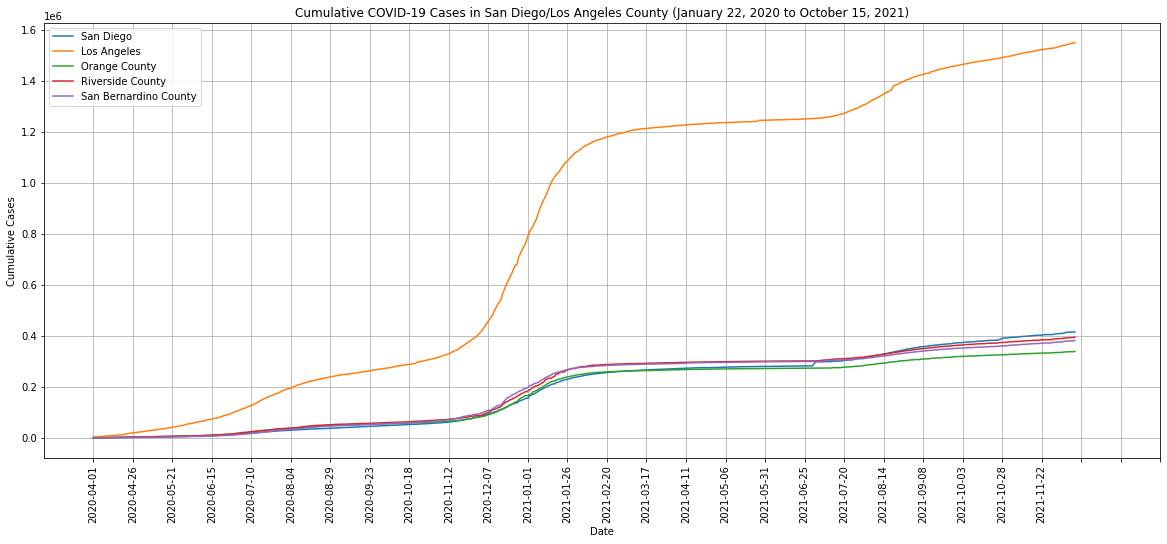

In [25]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
plt.plot(sd.date, sd.cases)
plt.plot(la.date, la.cases)
plt.plot(oc.date, oc.cases)
plt.plot(rs.date, rs.cases)
plt.plot(sb.date, sb.cases)


# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Cumulative Cases")

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 'Riverside County', 'San Bernardino County',
            'Trinity County', 'Mono County', 'Modoc County', 'Sierra County', 'Alpine County'])

ticks = range(0, 700, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Cumulative COVID-19 Cases in San Diego/Los Angeles County (January 22, 2020 to October 15, 2021)")
plt.grid()

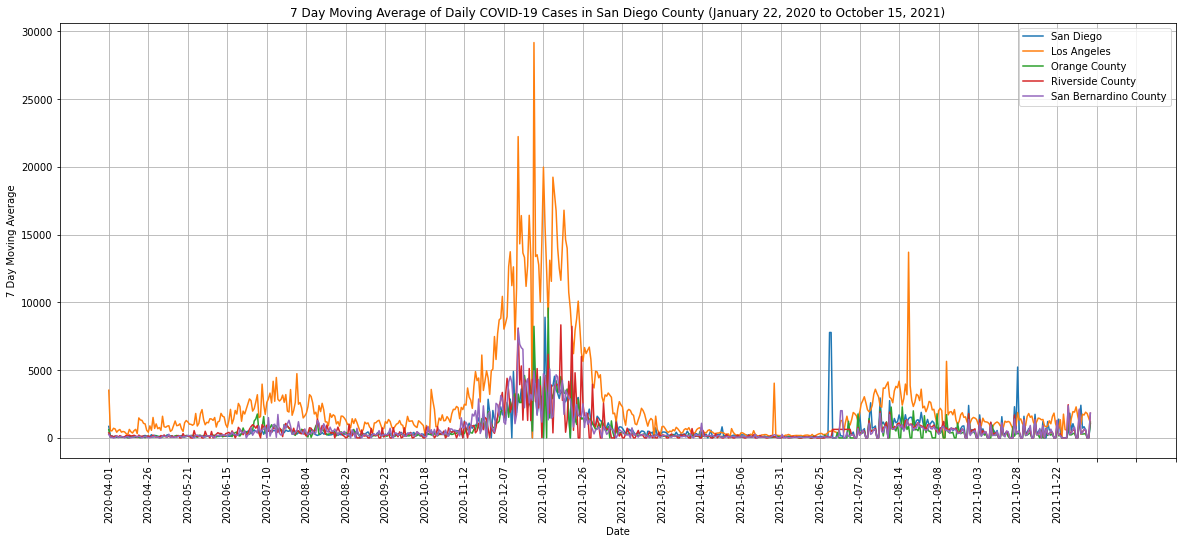

In [26]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Moving Average
plt.plot(sd.date, sd.Daily_Cases)
plt.plot(la.date, la.Daily_Cases)
plt.plot(oc.date, oc.Daily_Cases)
plt.plot(rs.date, rs.Daily_Cases)
plt.plot(sb.date, sb.Daily_Cases)


# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("7 Day Moving Average")

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 'Riverside County', 'San Bernardino County',
            'Trinity County', 'Mono County', 'Modoc County', 'Sierra County', 'Alpine County'])

ticks = range(0, 700, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("7 Day Moving Average of Daily COVID-19 Cases in San Diego County (January 22, 2020 to October 15, 2021)")
plt.grid()

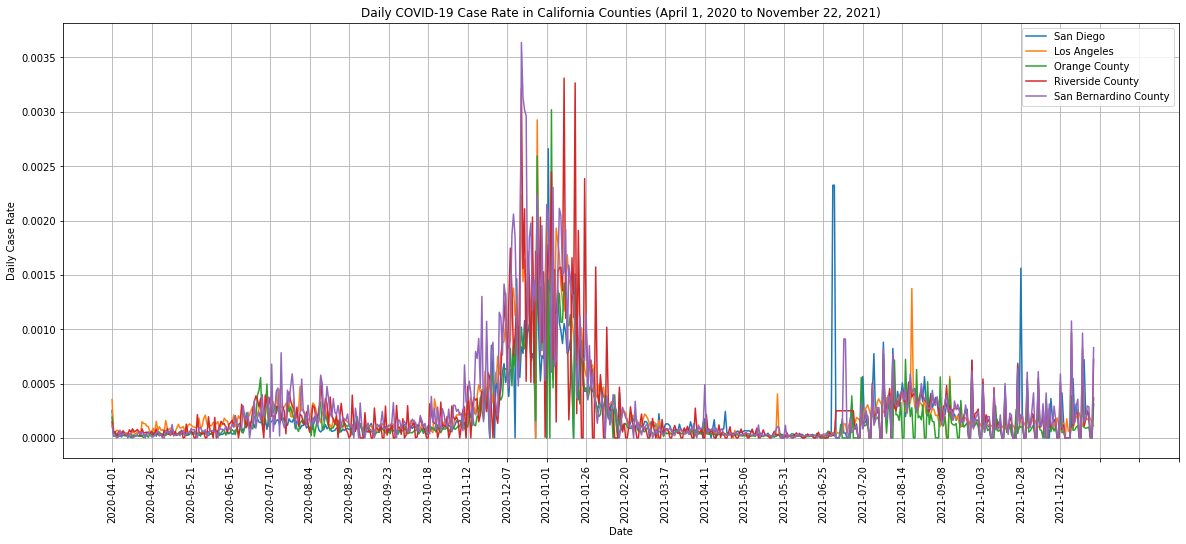

In [27]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
plt.plot(sd.date, sd.Case_Rate)
plt.plot(la.date, la.Case_Rate)
plt.plot(oc.date, oc.Case_Rate)
plt.plot(rs.date, rs.Case_Rate)
plt.plot(sb.date, sb.Case_Rate)

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 
            'Riverside County', 'San Bernardino County'])

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Case Rate")

ticks = range(0, 700, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Case Rate in California Counties (April 1, 2020 to November 22, 2021)")
plt.grid()

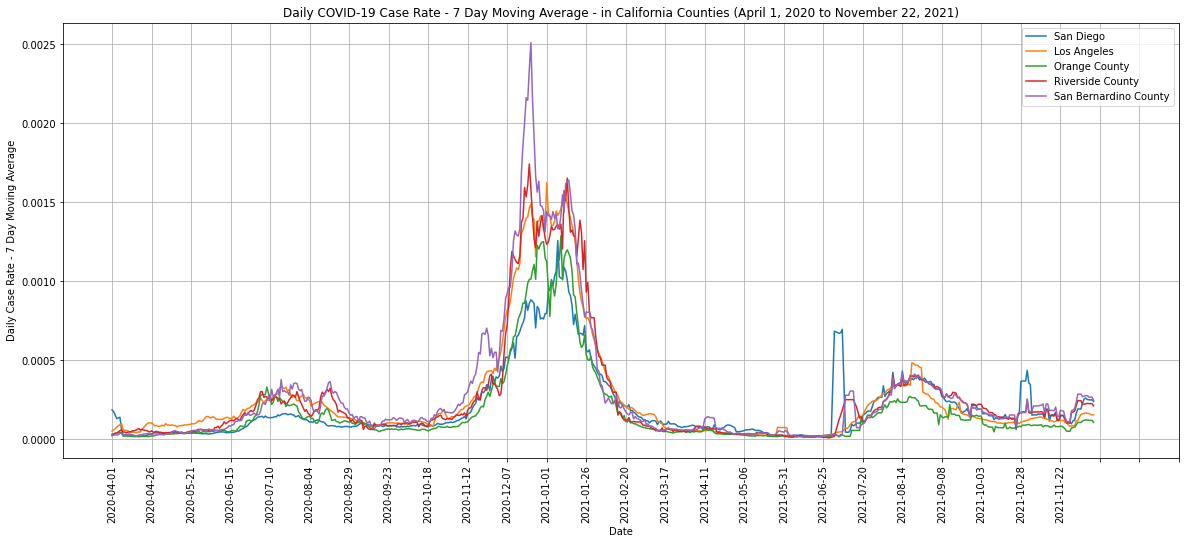

In [28]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
plt.plot(sd.date, sd.Avg_Rate)
plt.plot(la.date, la.Avg_Rate)
plt.plot(oc.date, oc.Avg_Rate)
plt.plot(rs.date, rs.Avg_Rate)
plt.plot(sb.date, sb.Avg_Rate)

# Create a legend for the different lines that will be displayed
plt.legend(['San Diego', 'Los Angeles', 'Orange County', 
            'Riverside County', 'San Bernardino County'])

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Case Rate - 7 Day Moving Average")

ticks = range(0, 700, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Case Rate - 7 Day Moving Average - in California Counties (April 1, 2020 to November 22, 2021)")
plt.grid()

In [29]:
means = []
for x in d:
  means.append(d[x]['Case_Rate'].mean())

In [30]:
#meansdict = {listy[i]: means[i] for i in range(0, len(listy), 1)}
mdf = pd.DataFrame()
mdf['county'] = listy
mdf['means'] = means

mdf.to_csv('County Case Rate Means.csv', index = False)

In [38]:
from scipy import stats

print('LA: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), la['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('OC: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), oc['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Riverside: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), rs['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('San Bernardino: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), sb['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Santa Clara: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), santa['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Alameda: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), alameda['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Sacramento: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), sacramento['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Contra Costa: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), cc['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))
print('Fresno: ', stats.ttest_ind(sd['Case_Rate'].sample(n = 100, random_state = 1), fc['Case_Rate'].sample(n = 100, random_state = 1), equal_var=False))

LA:  Ttest_indResult(statistic=-2.0605691220463855, pvalue=0.04085329434430013)
OC:  Ttest_indResult(statistic=0.8198730523703578, pvalue=0.4132838373638814)
Riverside:  Ttest_indResult(statistic=-1.6800677747060428, pvalue=0.09512400714635334)
San Bernardino:  Ttest_indResult(statistic=-2.4395038134118927, pvalue=0.016062924006950065)
Santa Clara:  Ttest_indResult(statistic=1.7862088972783117, pvalue=0.07571908834352956)
Alameda:  Ttest_indResult(statistic=2.1490166865989124, pvalue=0.03310931064962423)
Sacramento:  Ttest_indResult(statistic=0.36405447079913933, pvalue=0.7162098393883313)
Contra Costa:  Ttest_indResult(statistic=1.015561846377137, pvalue=0.3112104713994153)
Fresno:  Ttest_indResult(statistic=-2.1041557253537997, pvalue=0.036925708837011476)


A small p (≤ 0.05), reject the null hypothesis. This is strong evidence that the null hypothesis is invalid.
A large p (> 0.05) means the alternate hypothesis is weak, so you do not reject the null.

*   LA - reject the null
*   OC - do not reject null
*   Riverside - do not reject the null
*   San Bernardino - reject the null
*   Santa Clara - do not reject the null
*   Alameda - reject the null
*   Sacramento - do not reject the null
*   Costa Contra - do not reject the null
*   Fresno - reject the null

In [32]:
sd_vax = sd[sd['date'] >= '2021-04-15']
sd_vax = sd_vax[sd_vax['date'] <= '2021-11-27']

sd_case = sd[sd['date'] < '2021-04-15']

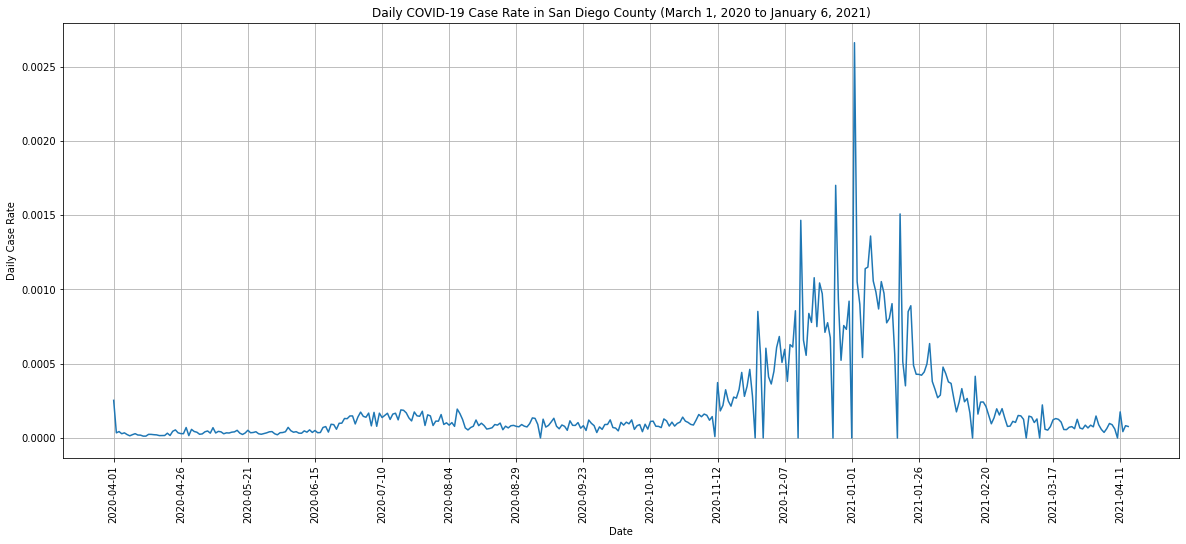

In [33]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
plt.plot(sd_case.date, sd_case.Case_Rate)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Case Rate")

ticks = range(0, 400, 25)
plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Case Rate in San Diego County (March 1, 2020 to January 6, 2021)")
plt.grid()

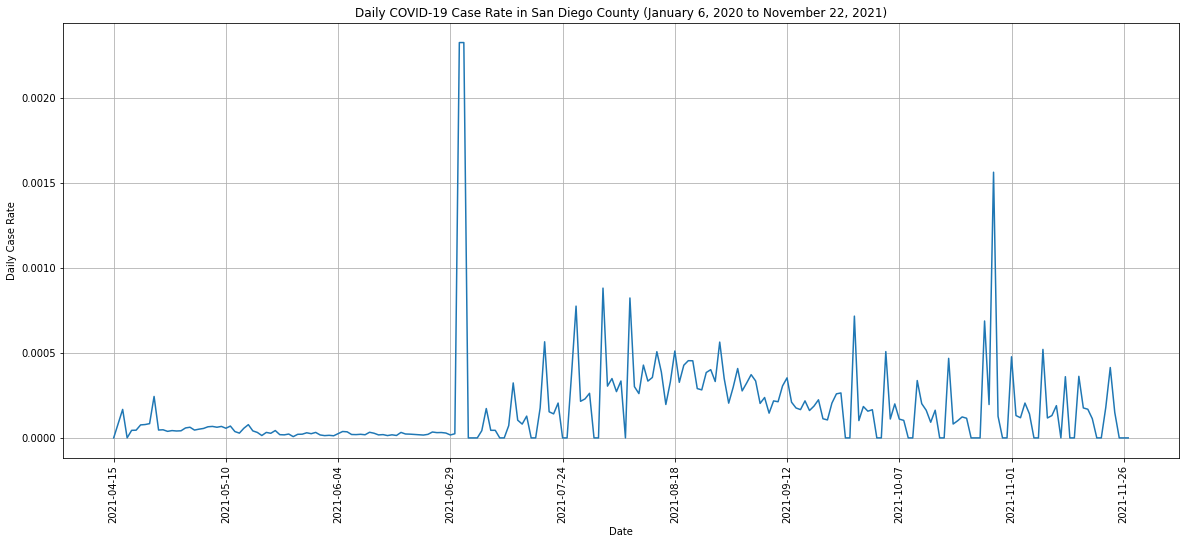

In [34]:
# Create a plot
plt.figure(figsize=(20, 8))

# Plotting the Cases
plt.plot(sd_vax.date, sd_vax.Case_Rate)

# Formatting the time series graph
plt.xlabel("Date")
plt.ylabel("Daily Case Rate")

ticks = range(0, 250, 25)

plt.xticks(ticks)
plt.xticks(rotation=90)

plt.title("Daily COVID-19 Case Rate in San Diego County (January 6, 2020 to November 22, 2021)")
plt.grid()

In [35]:
from scipy import stats

print('Before vs After Vaccine: ', stats.ttest_ind(sd_case['Daily_Cases'], sd_vax['Daily_Cases'], equal_var = False))

Before vs After Vaccine:  Ttest_indResult(statistic=1.7115834589213403, pvalue=0.08758295241150496)


In [43]:
sd_vax2 = sd[sd['date'] >= '2021-04-15']
sd_vax2 = sd_vax2[sd_vax2['date'] <= '2021-06-15']

sd_case2 = sd[sd['date'] < '2021-04-15']

sd_vaxld = sd[sd['date'] > '2021-06-15']

from scipy import stats

print('Before Vaccine vs After Vaccine and Lock Down End: ', stats.ttest_ind(sd_case2['Daily_Cases'].sample(n = 100, random_state = 1), sd_vaxld['Daily_Cases'].sample(n = 100, random_state = 1), equal_var = False))
print('Before Vaccine vs After Vaccine: ', stats.ttest_ind(sd_case2['Daily_Cases'].sample(n = 50, random_state = 1), sd_vax2['Daily_Cases'].sample(n = 50, random_state = 1), equal_var = False))
print('After Vaccine vs After Vaccine and Lock Down End: ', stats.ttest_ind(sd_vax2['Daily_Cases'].sample(n = 50, random_state = 1), sd_vaxld['Daily_Cases'].sample(n = 50, random_state = 1), equal_var = False))

Before Vaccine vs After Vaccine and Lock Down End:  Ttest_indResult(statistic=-0.2934434613397454, pvalue=0.7694920889568299)
Before Vaccine vs After Vaccine:  Ttest_indResult(statistic=4.692934111581787, pvalue=2.0671806634531253e-05)
After Vaccine vs After Vaccine and Lock Down End:  Ttest_indResult(statistic=-4.3275500827497355, pvalue=7.295156977595495e-05)


In [37]:
#link2 = 'https://api.covidactnow.org/v2/counties.timeseries.csv?apiKey=6b402fb107d14cac9ecf93a83992bc49'

#county_data = pd.read_csv(link2)

#county_data